In [3]:
from scipy.spatial import distance as dst
from collections import defaultdict,Counter,deque
import matplotlib.pyplot as plt
import numpy.random as npr
import igraph as ig
import pickle as pk
import itertools
import random
import heapq
import time
from collections import OrderedDict
import copy
import time
import math

In [4]:
WeightedSectorGraph=pk.load(open("Outputs/WeightedSectorGraph.pkl","rb"))
Centroids = pk.load(open("Outputs/CentroidDict.pkl", "rb"))
print(WeightedSectorGraph)

IGRAPH U-W- 1250 3610 --
+ attr: weight (e)
+ edges:
   0 --    1    2    3    4    7    8    9              849 --  505  508  840
841  842  846  848
   1 --    0    4    6    9                             850 --  852  854  855
857  891  897
   2 --    0    3    8   14   17                        851 --  853  857  858
859  912  917
   3 --    0    2    7   14   30   38                   852 --  630  637  850
855  856  857  859
   4 --    0    1    7                                  853 --  851  854  857
858  862  865  868
   5 --                                                 854 --  850  853  857
868  891  892
   6 --    1    9   41   45                             855 --  599  637  850
852  897
   7 --    0    3    4   30   35                        856 --  630  635  852
859  910
   8 --    0    2    9   11   17   44   47              857 --  850  851  852
853  854  859
   9 --    0    1    6    8   44   45                   858 --  851  853  865
912  916
  10 --   13   16   19  171

In [5]:
from collections import deque
class Chromosome:
    def __init__(self,path,fitness):
        self.path=path
        self.fitness=fitness
def chunks(lst, n):
    B=[]
    B.append(lst[:n])
    for i in range(n, len(lst), n-1):
        tmp=[]
        tmp.append(B[-1][-1])
        tmp+=lst[i:i+n-1]
        B.append(tmp)
    retPairArr=[]
    for i in B:
        retPairArr.append([i[0],i[-1]])
    return retPairArr

In [216]:
#ChangWook Algorithm
from multiprocessing import Process,Pipe
def ChangWookCrossover(G,ChromosomeA, ChromosomeB):
    setB=set(ChromosomeB.path)
    CommonVertex = [x for x in ChromosomeA.path if x in setB]
    if(len(CommonVertex)<=2):
        return [ChromosomeA, ChromosomeB]
    CommonVertex.pop(0)
    CommonVertex.pop()
    IndexWithCommonVertex=[]
    for vertex in CommonVertex:
        IndexWithCommonVertex.append((ChromosomeA.path.index(vertex),ChromosomeB.path.index(vertex)))
    CrossoverIndexPair=random.choice(IndexWithCommonVertex)
    Path1=ChromosomeA.path[:CrossoverIndexPair[0]+1]+ChromosomeB.path[CrossoverIndexPair[1]+1:]
    Path2=ChromosomeB.path[:CrossoverIndexPair[1]+1]+ChromosomeA.path[CrossoverIndexPair[0]+1:]  #OPT 1 & 2
    f1=PathFitness(G,Path1)
    f2=PathFitness(G,Path2)
    ret=[]
    if(f1>ChromosomeA.fitness):
        ret.append(Chromosome(Path1,f1))
    else:
        ret.append(ChromosomeA)
    if(f2>ChromosomeB.fitness):
        ret.append(Chromosome(Path2,f2))  #OPT 1.5
    else:
        ret.append(ChromosomeB)
    return ret
    #return [Chromosome(Path1,PathFitness(G,Path1)),Chromosome(Path2,PathFitness(G,Path2))]

    #1 2 3 4 5 6 9 -> 1 2 3 4 6 7 9 
    #  1 2 8 5 6 7 9 -> 1 2 8 4 5 6 9

def ChangWookSelection(Population,SelectionSize):
    size=int(SelectionSize)
    SelectedChromosomes=[]
    NumSelected=0
    #PopulationCopy = copy.deepcopy(Population)
    while(NumSelected!=size):
        IndexPair=random.sample(range(len(Population)),2)
        PickedIndex=IndexPair[1]
        if(Population[IndexPair[0]].fitness>=Population[IndexPair[1]].fitness):
            PickedIndex=IndexPair[0]
        SelectedChromosomes.append(copy.deepcopy(Population[PickedIndex]))
        NumSelected+=1
        Population.pop(PickedIndex)
    return SelectedChromosomes

    # 2 Random Chromosomes chm1>chm2 -> SelectedChm.append(chm1)

def ChangWookMutation(G,Population,start,end,MutationRate):
    PopulationAvail = sorted(Population, key=lambda x: x.fitness, reverse=True)
    PopulationAvail=PopulationAvail[int(len(Population)/2):]
    if(len(PopulationAvail)==0):
        return
    MutationChance=(1-MutationRate)
    MutationProbability=random.random()
    if MutationProbability>=MutationChance:
        chromosome=random.choice(PopulationAvail)
        StartIndex=random.choice(range(len(chromosome.path)-1))
        StartVertex=chromosome.path[StartIndex]
        chromosome.path=chromosome.path[:StartIndex]
        Newpath=[StartVertex]
        UnionSet=set()
        UnionSet.add(StartVertex)
        while(True):
            viableSet=set(G.neighbors(Newpath[-1]))-UnionSet
            if(len(viableSet)==0):
                Newpath=[StartVertex]
                UnionSet=set()
                UnionSet.add(StartVertex)
                continue
            else:
                ChosenNeighbor=random.choice(tuple(viableSet))
                Newpath.append(ChosenNeighbor)
                UnionSet.add(ChosenNeighbor)
                if(Newpath[-1]==end):
                    chromosome.path+=Newpath
                    chromosome.fitness=PathFitness(G,chromosome.path)
                    break
    # 1 2 3 4 5 6 7 8 9 OD(1,9) chose 1 2 3 4 5 '6' 7 8 9 -> 1 2 3 4 5 '6 10 11 12 9'
def ChangWookRepair(G,population):
    for chromosome in population:
        d=defaultdict(int)
        newpath=[]
        for index,vertex in enumerate(chromosome.path):
            d[vertex]=index
        index=0
        while(index<len(chromosome.path)):
            newpath.append(chromosome.path[index])
            index=d[chromosome.path[index]]+1
        chromosome.path=[*newpath]
        chromosome.fitness=PathFitness(G,chromosome.path)

def getInitPopulation(G,Population,population_size,start,end):
    while len(Population)!=population_size:
        gotInitPath=False
        while not gotInitPath:
            path=[start]
            pathSet=set(path)
            while not gotInitPath:
                viableSet=set(G.neighbors(path[-1]))-pathSet
                if(len(viableSet)==0):
                    path=[start]
                    pathSet=set(path)
                else:
                    pickedVertex=random.choice(tuple(viableSet))
                    path.append(pickedVertex)
                    pathSet.add(pickedVertex)
                    if(path[-1]==end):
                        Population.append(Chromosome(path,PathFitness(G,path)))
                        gotInitPath=True
#     chunkSize=max(10,int(len(Population[-1].path)/3))
#     cks=chunks(path,chunkSize)
    
    
#         path=[start]
#         for cnkNum in range(len(cks)):
#             cnkSt=cks[cnkNum][0]
#             cnkEd=cks[cnkNum][1]
#             partpath=[cnkSt]
#             unionSet=set(partpath)
#             while(partpath[-1]!=cnkEd):        
#                 viableSet=set(G.neighbors(partpath[-1]))-unionSet
#                 if(len(viableSet)==0):
#                     partpath=[cnkSt]
#                     unionSet=set(partpath)
#                 else:
#                     nextVer=random.choice(tuple(viableSet))
#                     partpath.append(nextVer)
#                     unionSet.add(nextVer)
#             path.pop()
#             path+=partpath   
#         newpath=[]
#         for vertex in path:
#             if(vertex in newpath):
#                 newpath=newpath[:newpath.index(vertex)+1]
#             else:
#                 newpath.append(vertex)
#         Population.append(Chromosome(newpath,PathFitness(G,newpath)))
#     send_end.send(Population)

def InitialPopulation(G,Population,PopulationSize,Start,End):
    jobs = []
    pipe_list = []
    for i in range(8):
        recv_end, send_end = Pipe(False)
        p = Process(target=getInitPopulation, args=(WeightedSectorGraph,send_end,int(PopulationSize/8),Start,End))
        jobs.append(p)
        pipe_list.append(recv_end)
        p.start()

    result_list = [x.recv() for x in pipe_list]
    for proc in jobs:
        proc.join()
    for df in result_list:
        Population+=df

def ChangWook(G,start,end,PopulationSize,NumberOfGenerations,MutationRate,SelectionSize):
    Population=[]
    #Inital Population
    initst=time.time()
    getInitPopulation(G,Population,PopulationSize,start,end)
    initen=time.time()
    print(initen-initst)
    Genst=time.time()
    PreDiff=0
    SelDiff=0
    CroDiff=0
    MutDiff=0
    RepDiff=0
    EliDiff=0
    gennum=0
    for Generation in range(NumberOfGenerations):
        gennum+=1
        prest=time.time()
#         seen=[]
#         PopNoDupli=[]
#         Extra=None
#         for chromosome in Population:
#             if(chromosome.path not in seen):
#                 seen.append(chromosome.path)
#                 PopNoDupli.append(chromosome)
#             else:
#                 print("DUPLICATE")
#                 Extra=chromosome
#         if(len(PopNoDupli)%2!=0 and Extra is not None):
#             PopNoDupli.append(Extra)
#         Population=copy.deepcopy(PopNoDupli)
        PopulationSize=len(Population)
        SelectionSize=PopulationSize/2
        preed=time.time()
        PreDiff+=(preed-prest)
        if(PopulationSize<=2):
            break
        #Selection
        selst=time.time()
        SelectedChm=ChangWookSelection(Population,SelectionSize)
        seled=time.time()
        SelDiff+=(seled-selst)
        
        #Crossover
        crost=time.time()
#         A=[]
#         while(len(SelectedChm)>1):
#             cross=random.sample(SelectedChm,2)
#             NewChm=ChangWookCrossover(G,cross[0],cross[1])               
#             SelectedChm.remove(cross[0])
#             SelectedChm.remove(cross[1])
#             for chm in Population:
#                 if(chm.path==cross[0].path):   #OPT 2
#                     Population.remove(chm)
#             for chm in Population:
#                 if(chm.path==cross[1].path):
#                     Population.remove(chm) 
#             A+=NewChm
#         croed=time.time()
#         CroDiff+=(croed-crost)
#         Population+=A
        crost=time.time()
        while(len(SelectedChm)>1):
            cross=random.sample(SelectedChm,2)
            NewChm=ChangWookCrossover(G,cross[0],cross[1])          #opt 1 nd 1.5     
            SelectedChm.remove(cross[0])
            SelectedChm.remove(cross[1])
            Population+=NewChm
        croed=time.time()
        CroDiff+=(croed-crost)
        
        #Mutation
        mutst=time.time()
        ChangWookMutation(G,Population,start,end,MutationRate)
        muten=time.time()
        MutDiff+=(muten-mutst)
        
        #Repair
        repst=time.time()
        ChangWookRepair(G,Population)
        repen=time.time()
        RepDiff+=(repen-repst)
        #Elimination
        elist=time.time()
        #Population = sorted(Population, key=lambda x: x.fitness, reverse=True)[:PopulationSize]
        elien=time.time()
        EliDiff+=(elien-elist)
    Genen=time.time()
    print("Time for all gen",Genen-Genst)
    print("Prelim",PreDiff)
    print("Selection",SelDiff)
    print("Crossover",CroDiff)
    print("Mutation",MutDiff)
    print("Repair",RepDiff)
    print("Elimination",EliDiff)
    print("NumberOfGenerations",gennum)
    RetPaths=[]
    RetChm=[]
    for chromosome in Population:
        if(chromosome.path not in RetPaths):
                RetPaths.append(chromosome.path)
                RetChm.append(chromosome)
    RetChm=max(RetChm, key=lambda x: x.fitness)
    return RetChm

In [217]:
def GetAngle (p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dX = x2 - x1
    dY = y2 - y1
    rads = math.atan2 (-dY, dX)
    return math.degrees (rads)
def getAngle(A,B,C):
    pt1=Centroids[A]
    pt2=Centroids[B]
    pt3=Centroids[C]
    a=GetAngle(pt1,pt2)
    b=GetAngle(pt3,pt2)
    if(abs(b-a))>180:
        return 180-(360-abs(b-a))
    else:
        return 180-(abs(b-a))

In [218]:
def PathFitness(G,Path):
    global SectorCounts
    cur=Path[0]
    path_length=0
    sector_len=len(Path)-2
    for pathIdx in range(1,len(Path)):
        path_length+=G.es[G.get_eid(cur, Path[pathIdx])]["weight"]
        cur=Path[pathIdx] #8,6,9,7 -> Total path len += distance between  any 2 sectors
        
    TrafficFactor=1
    Curtime=0
    for sector in Path:
        TrafficFactor+=SectorCounts[sector][Curtime]
        Curtime+=1
    
    angle=1
    AirportTraffic=SectorCounts[Path[-1]][Curtime-1]+1 
    for i in range(len(Path)-2):
        angle+=getAngle(Path[i],Path[i+1],Path[i+2])
    if(TrafficFactor==1):
        return 1/(path_length*(1.5)*angle*AirportTraffic* sector_len)
    else:
        return 1/(path_length*(TrafficFactor)*angle*AirportTraffic*sector_len)

In [219]:
def getPaths(G,start,end):
    pop_size=4000
    gen_size=250
    Mut_Rate=1
    Selection_Size=pop_size/2
    paths=ChangWook(G,start,end,pop_size,gen_size,Mut_Rate,Selection_Size).path
    return paths

In [220]:
SectorCounts = defaultdict(dict,{ k:defaultdict(int) for k in range(1250)})
od=[(6, 662),(6, 662),(6, 662),(6, 662)]
Paths= dict()
initstGA=time.time()
for odPairIdx,odPair in enumerate(od[:8]):
    path=getPaths(WeightedSectorGraph,odPair[0],odPair[1])
    Curtime=0
    for sector in path:
        SectorCounts[sector][Curtime]+=1
        Curtime+=1
    Paths[odPairIdx]=path
    print(odPair)
    print('\n\n')
initenGA=time.time()
print(f"\n\n\n\n GA TIME \t {initenGA-initstGA}")
A=[]
for i in Paths.keys():
    A.append(Paths[i])
pk.dump(A,open(f"GA_Output_1.5_500.pkl","wb"))

49.036319732666016
Time for all gen 134.10345268249512
Prelim 0.0002498626708984375
Selection 13.87436580657959
Crossover 37.91343331336975
Mutation 1.7642831802368164
Repair 80.54983353614807
Elimination 6.580352783203125e-05
NumberOfGenerations 250
(6, 662)



42.39779329299927
Time for all gen 112.52221608161926
Prelim 0.00021982192993164062
Selection 11.359401941299438
Crossover 31.96619462966919
Mutation 1.8051655292510986
Repair 67.3902850151062
Elimination 5.316734313964844e-05
NumberOfGenerations 250
(6, 662)



42.8515202999115
Time for all gen 113.62344288825989
Prelim 0.00021648406982421875
Selection 11.525379419326782
Crossover 32.70787286758423
Mutation 1.5888934135437012
Repair 67.80011773109436
Elimination 5.4836273193359375e-05
NumberOfGenerations 250
(6, 662)



42.591376304626465
Time for all gen 118.68995642662048
Prelim 0.0002200603485107422
Selection 11.825715780258179
Crossover 34.08140707015991
Mutation 1.7674329280853271
Repair 71.01421213150024
Elimination 5.84

In [23]:
#END OF GA DONT MODIFY CELLS BELOW

In [828]:
KVals = pk.load(open("KDict.pkl", "rb"))
sectorTraffic=dict()
sectorMax=dict()
for sector in range(1250):
    sectorSum=0
    sectorTimeSum=0
    trafficMax=0
    for timeT in SectorCounts[sector]:
        if(SectorCounts[sector][timeT]>0):
            sectorSum+=SectorCounts[sector][timeT]
            sectorTimeSum+=1
            trafficMax=max(trafficMax,SectorCounts[sector][timeT])
    sectorMax[sector]=trafficMax
    if(sectorSum)!=0:
        sectorTraffic[sector]=sectorSum/sectorTimeSum
    else:
        sectorTraffic[sector]=0
sectorTrafficSorted = dict(sorted(sectorTraffic.items(), key=lambda item: item[1],reverse=True))
sectorMaxSorted = dict(sorted(sectorMax.items(), key=lambda item: item[1],reverse=True))
KValsSorted = dict(sorted(KVals.items(), key=lambda item: item[1],reverse=True))
for i in list(sectorTrafficSorted.keys()):
    print(f"{i}\t{sectorTrafficSorted[i]}")

94	20.0
55	5.0
99	4.0
98	2.5
52	2.0
56	2.0
59	2.0
60	2.0
63	2.0
69	2.0
90	2.0
61	1.75
92	1.75
62	1.6666666666666667
95	1.6666666666666667
284	1.6666666666666667
289	1.6666666666666667
662	1.6666666666666667
257	1.625
287	1.6
53	1.5
54	1.5
91	1.5
255	1.5
282	1.5
485	1.5
486	1.5
97	1.3333333333333333
286	1.3333333333333333
64	1.25
660	1.1818181818181819
281	1.1666666666666667
470	1.1428571428571428
476	1.1428571428571428
749	1.1428571428571428
709	1.1
50	1.0
51	1.0
57	1.0
58	1.0
65	1.0
66	1.0
67	1.0
68	1.0
84	1.0
85	1.0
93	1.0
96	1.0
231	1.0
232	1.0
234	1.0
235	1.0
237	1.0
238	1.0
240	1.0
241	1.0
242	1.0
244	1.0
245	1.0
246	1.0
250	1.0
251	1.0
252	1.0
253	1.0
254	1.0
256	1.0
258	1.0
259	1.0
261	1.0
262	1.0
264	1.0
270	1.0
272	1.0
273	1.0
275	1.0
276	1.0
278	1.0
279	1.0
283	1.0
285	1.0
288	1.0
290	1.0
293	1.0
294	1.0
296	1.0
297	1.0
298	1.0
299	1.0
450	1.0
451	1.0
452	1.0
453	1.0
454	1.0
456	1.0
457	1.0
461	1.0
462	1.0
463	1.0
465	1.0
468	1.0
469	1.0
471	1.0
474	1.0
475	1.0
477	1.0
478	1.

In [829]:
sector=662
for timeT in SectorCounts[sector]:
    if(SectorCounts[sector][timeT]>0):
        print(timeT,SectorCounts[sector][timeT])

29 1
31 1
27 2
30 1
26 2
28 2
25 2
22 2
23 2
24 1
21 1
20 3


In [582]:
#FOR 18 September
KVals = pk.load(open("KDict.pkl", "rb"))
sectorTraffic=dict()
sectorMax=dict()
for sector in range(1250):
    sectorSum=0
    sectorTimeSum=0
    trafficMax=0
    for timeT in SectorCounts[sector]:
        if(SectorCounts[sector][timeT]>0):
            sectorSum+=SectorCounts[sector][timeT]
            sectorTimeSum+=1
            trafficMax=max(trafficMax,SectorCounts[sector][timeT])
    sectorMax[sector]=trafficMax
    if(sectorSum)!=0:
        sectorTraffic[sector]=sectorSum/sectorTimeSum
    else:
        sectorTraffic[sector]=0
sectorTrafficSorted = dict(sorted(sectorTraffic.items(), key=lambda item: item[1],reverse=True))
sectorMaxSorted = dict(sorted(sectorMax.items(), key=lambda item: item[1],reverse=True))
KValsSorted = dict(sorted(KVals.items(), key=lambda item: item[1],reverse=True))
for i in list(sectorTrafficSorted.keys()):
    print(f"{i}\t{sectorTrafficSorted[i]}")

93	5.0
954	4.956521739130435
1138	4.703703703703703
519	4.181818181818182
1129	4.142857142857143
582	3.838709677419355
1112	3.7
99	3.6666666666666665
882	3.5294117647058822
7	3.484848484848485
422	3.3448275862068964
94	3.3333333333333335
1124	3.2857142857142856
989	3.260869565217391
1122	3.25
1118	3.076923076923077
1087	3.066666666666667
853	3.0454545454545454
824	3.0303030303030303
533	3.0
962	3.0
1065	3.0
1106	3.0
1206	3.0
829	2.9375
1056	2.9285714285714284
768	2.9166666666666665
940	2.9166666666666665
1131	2.8181818181818183
1126	2.8
1127	2.8
34	2.7777777777777777
1202	2.772727272727273
775	2.764705882352941
953	2.7083333333333335
1111	2.7
1068	2.6956521739130435
1203	2.6666666666666665
987	2.6363636363636362
46	2.625
1084	2.6153846153846154
52	2.6
803	2.6
869	2.6
1092	2.5714285714285716
1123	2.5714285714285716
929	2.5294117647058822
42	2.5
967	2.5
1130	2.5
91	2.48
1077	2.48
1141	2.466666666666667
980	2.4615384615384617
59	2.4545454545454546
479	2.433333333333333
861	2.4230769230769

In [583]:
for i in list(sectorMaxSorted.keys()):
    print(f"{i}\t{sectorMaxSorted[i]}")

1138	68
582	56
954	56
519	51
1112	46
1129	43
7	39
1202	38
824	34
882	30
91	26
23	25
989	25
775	23
1122	23
94	22
422	21
940	20
1118	20
707	19
953	18
146	17
1087	17
768	16
853	16
962	16
1084	16
25	15
1123	15
1065	14
512	13
609	13
929	13
952	13
1068	13
1075	13
1077	13
1092	13
1124	12
1134	12
1137	12
1146	12
92	11
511	11
528	11
585	11
588	11
992	11
1125	11
1130	11
1131	11
3	10
34	10
533	10
957	10
1113	10
0	9
201	9
581	9
584	9
593	9
615	9
945	9
958	9
994	9
1111	9
1117	9
1126	9
21	8
22	8
30	8
97	8
510	8
517	8
583	8
589	8
691	8
822	8
987	8
990	8
1056	8
1110	8
1119	8
1127	8
1144	8
1208	8
20	7
26	7
35	7
42	7
49	7
98	7
99	7
514	7
524	7
550	7
552	7
554	7
652	7
861	7
905	7
982	7
1105	7
1116	7
1121	7
1128	7
1141	7
1143	7
1147	7
1170	7
1188	7
1189	7
1206	7
14	6
48	6
54	6
59	6
87	6
315	6
479	6
486	6
553	6
558	6
565	6
610	6
616	6
618	6
694	6
697	6
728	6
760	6
766	6
772	6
829	6
869	6
881	6
883	6
885	6
889	6
911	6
949	6
980	6
984	6
986	6
1052	6
1067	6
1079	6
1115	6
1120	6
1136	6
1140	6
1145	6
1165	6
116

In [584]:
for i in list(KValsSorted.keys()):
    print(f"{i}\t{KVals[i]}")

824	93
582	71
954	62
519	56
989	53
1122	51
422	46
882	40
7	39
1138	39
23	38
1112	38
146	37
1129	34
953	28
1118	27
1124	27
962	26
159	25
707	25
940	25
958	23
883	22
201	21
22	20
91	20
945	19
947	19
1123	19
768	18
775	18
981	18
982	18
1117	18
1202	18
593	17
662	17
822	17
829	17
988	17
1111	17
205	16
615	16
853	16
862	16
980	16
1125	16
0	15
147	15
429	15
524	15
553	15
609	15
869	15
949	15
974	15
990	15
1116	15
42	14
181	14
511	14
732	14
734	14
766	14
889	14
948	14
976	14
1130	14
25	13
49	13
354	13
421	13
828	13
866	13
867	13
886	13
1076	13
1087	13
1121	13
1143	13
1144	13
16	12
54	12
94	12
140	12
180	12
301	12
551	12
559	12
592	12
616	12
663	12
669	12
700	12
779	12
861	12
863	12
868	12
943	12
952	12
986	12
991	12
1061	12
1062	12
1067	12
1070	12
1096	12
1100	12
1115	12
1131	12
1147	12
1151	12
34	11
55	11
110	11
141	11
144	11
182	11
183	11
202	11
355	11
420	11
526	11
589	11
594	11
667	11
811	11
819	11
864	11
879	11
900	11
927	11
929	11
932	11
950	11
961	11
987	11
994	11
1064	11
1071	11
1078	

(0.0, 1500.0)

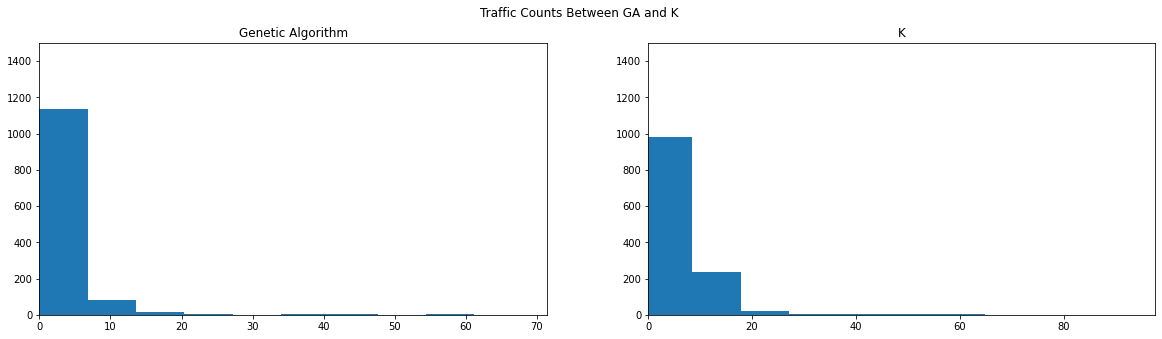

In [642]:
GA_Model=list(sectorMaxSorted.values())
K_Orig = list(KValsSorted.values())
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
X=min(min(GA_Model,K_Orig))
fig.suptitle('Traffic Counts Between GA and K')
ax1.hist(GA_Model)
ax1.set_title("Genetic Algorithm")
ax1.set_xlim(X)
ax1.set_ylim(0,1500)
ax2.hist(K_Orig)
ax2.set_title("K")
ax2.set_xlim(X)
ax2.set_ylim(0,1500)

In [597]:
hotspotSectors=[]
for sector in KValsSorted:
    if(KValsSorted[sector]<=25 and KValsSorted[sector]>=8):
        hotspotSectors.append(sector)
print(len(hotspotSectors))

367


In [599]:
hotspotSectorsGA=[]
for sector in sectorMaxSorted:
    if(sectorMaxSorted[sector]<=25 and sectorMaxSorted[sector]>=8):
        hotspotSectorsGA.append(sector)
print(len(hotspotSectorsGA))

75


In [622]:
freq=dict()
for count in range(30):
    tr=0
    for sector in sectorMaxSorted:
        if(sectorMaxSorted[sector]==count):
            tr+=1
    freq[count]=tr
for i in freq:
    print(i,freq[i])

0 37
1 285
2 359
3 225
4 114
5 74
6 43
7 27
8 18
9 12
10 5
11 9
12 4
13 8
14 1
15 2
16 4
17 2
18 1
19 1
20 2
21 1
22 1
23 2
24 0
25 2
26 1
27 0
28 0
29 0


In [623]:
Kfreq=dict()
for count in range(30):
    tr=0
    for sector in KValsSorted:
        if(KValsSorted[sector]==count):
            tr+=1
    Kfreq[count]=tr
for i in Kfreq:
    print(i,Kfreq[i])

0 2
1 12
2 49
3 83
4 161
5 178
6 206
7 164
8 115
9 82
10 38
11 38
12 31
13 13
14 10
15 11
16 6
17 6
18 6
19 3
20 2
21 1
22 1
23 1
24 0
25 3
26 1
27 2
28 1
29 0


In [639]:
import pandas as pd
data={"SectorCount":[i for i in range(30)],
     "GA Model":[freq[sector] for sector in range(30)],
     "Real World":[Kfreq[sector] for sector in range(30)]}
SectorDataFrame=pd.DataFrame(data)

In [640]:
SectorDataFrame

,SectorCount,GA Model,Real World
0,0,37,2
1,1,285,12
2,2,359,49
3,3,225,83
4,4,114,161
5,5,74,178
6,6,43,206
7,7,27,164
8,8,18,115
9,9,12,82


<AxesSubplot:xlabel='SectorCount', ylabel='Number of sectors'>

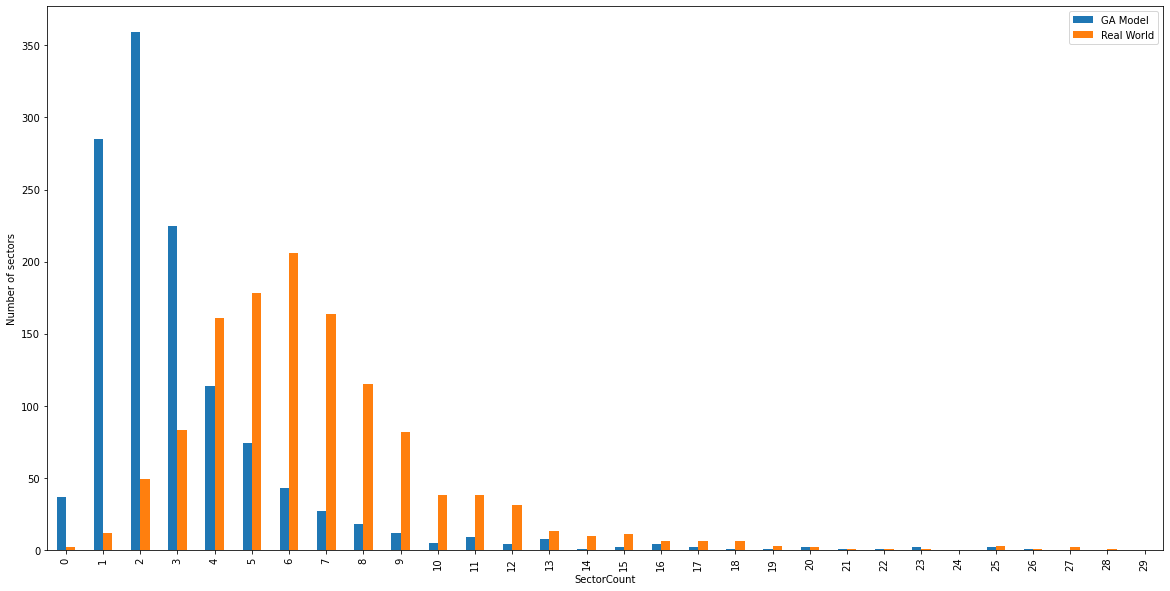

In [641]:
SectorDataFrame.plot.bar(x='SectorCount',figsize=(20,10),ylabel = 'Number of sectors')

In [40]:
# def Dijkstra(G,start,end):
#     return G.get_shortest_paths(
#         start,
#         to=end,
#         weights=G.es["weight"],
#         output="vpath",
#     )[0]